In [2]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=81815d09c4ef7a80b7350cb1f4b3e1810b8d14483341c76218bb8315332c4409
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


Setting up the imports and stock universe

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import ta  # for technical indicators
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Define stock universe
tickers = [
     "AAPL", "MSFT", "AMZN", "GOOGL", "GOOG", "TSLA", "V",
    "JNJ", "WMT", "JPM", "MA", "PG", "UNH", "NVDA", "HD", "DIS", "PYPL",
    "VZ", "ADBE", "NFLX", "INTC", "CMCSA", "KO", "PFE", "PEP", "T", "MRK",
    "ABT", "CSCO", "XOM", "CVX", "NKE", "LLY", "ORCL", "MCD", "DHR", "COST",
    "WFC", "MDT", "ACN", "AVGO", "TXN", "HON", "QCOM", "AMGN", "BMY", "UNP",
    "LOW", "NEE", "UPS", "MS", "IBM", "PM", "SBUX", "LIN", "AMD", "GS",
    "CAT", "BLK", "ISRG", "GE", "AMT", "CVS", "TMO", "MMM", "SPGI", "AXP",
    "SYK", "PLD", "MDLZ", "LMT", "INTU", "BA", "BKNG", "DE", "ADP", "SCHW",
    "MO", "CI", "GILD", "ZTS", "DUK", "SO", "MMC", "TGT", "CB", "BDX",
    "ADI", "APD", "C", "REGN", "EL", "EW", "ITW", "PNC", "NSC", "USB", "CRM", "SNOW", "SHOP", "SQ", "ROKU", "DOCU", "UBER", "LYFT", "ETSY",
    "ZM", "PINS", "TWLO", "SPOT", "FSLY", "NET", "DDOG", "CRWD", "OKTA", "ZS",
    "MDB", "TEAM", "SMAR", "DOCS", "ASAN", "BILL", "MNDY", "S", "SNAP", "PTON",
    "AFRM", "RBLX", "PLTR", "NIO", "XPEV", "LI", "LCID", "RIVN", "NKLA", "U",
    "MRVL", "SE", "RNG", "ESTC"]

Data collection functions

In [5]:
def collect_historical_data(tickers):
    """Collect historical price data for given tickers"""
    historical_data = {}
    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)
            hist = stock.history(period="2y")
            historical_data[ticker] = hist
            print(f"Collected data for {ticker}")
            time.sleep(1)  # Prevent rate limiting
        except Exception as e:
            print(f"Error collecting data for {ticker}: {e}")
    return historical_data

def collect_financial_data(tickers):
    """Collect financial statements and basic info for given tickers"""
    financial_data = {}
    basic_info = {}

    for ticker in tickers:
        try:
            stock = yf.Ticker(ticker)

            # Get financial statements
            financial_data[ticker] = {
                'financials': stock.financials,
                'balance_sheet': stock.balance_sheet,
                'cashflow': stock.cashflow
            }

            # Get basic info
            info = stock.info
            basic_info[ticker] = {
                'currentPrice': info.get('currentPrice', None),
                'marketCap': info.get('marketCap', None),
                'trailingPE': info.get('trailingPE', None),
                'priceToBook': info.get('priceToBook', None),
                'debtToEquity': info.get('debtToEquity', None),
                'returnOnEquity': info.get('returnOnEquity', None),
                'beta': info.get('beta', None)
            }

            print(f"Collected financials for {ticker}")
            time.sleep(1)

        except Exception as e:
            print(f"Error collecting financials for {ticker}: {e}")

    return financial_data, basic_info

# Run data collection
historical_data = collect_historical_data(tickers)
financial_data, basic_info = collect_financial_data(tickers)

Collected data for AAPL
Collected data for MSFT
Collected data for AMZN
Collected data for GOOGL
Collected data for GOOG
Collected data for TSLA
Collected data for V
Collected data for JNJ
Collected data for WMT
Collected data for JPM
Collected data for MA
Collected data for PG
Collected data for UNH
Collected data for NVDA
Collected data for HD
Collected data for DIS
Collected data for PYPL
Collected data for VZ
Collected data for ADBE
Collected data for NFLX
Collected data for INTC
Collected data for CMCSA
Collected data for KO
Collected data for PFE
Collected data for PEP
Collected data for T
Collected data for MRK
Collected data for ABT
Collected data for CSCO
Collected data for XOM
Collected data for CVX
Collected data for NKE
Collected data for LLY
Collected data for ORCL
Collected data for MCD
Collected data for DHR
Collected data for COST
Collected data for WFC
Collected data for MDT
Collected data for ACN
Collected data for AVGO
Collected data for TXN
Collected data for HON
Co

In [6]:
def calculate_metrics(tickers, historical_data, financial_data, basic_info):
    """Calculate financial metrics for each stock"""
    metrics_list = []

    for ticker in tickers:
        try:
            info = basic_info[ticker]
            fins = financial_data[ticker]['financials']
            balance = financial_data[ticker]['balance_sheet']
            price_data = historical_data[ticker]

            # Calculate Revenue Growth
            try:
                revenue_growth = (
                    (fins.loc['Total Revenue'].iloc[0] - fins.loc['Total Revenue'].iloc[1]) /
                    fins.loc['Total Revenue'].iloc[1]
                ) if 'Total Revenue' in fins.index else None
            except:
                revenue_growth = None

            # Calculate ROE
            try:
                roe = (
                    fins.loc['Net Income'].iloc[0] /
                    balance.loc['Total Stockholder Equity'].iloc[0]
                ) if 'Net Income' in fins.index and 'Total Stockholder Equity' in balance.index else None
            except:
                roe = None

            # Calculate 6-month return
            try:
                returns = price_data['Close'].pct_change(periods=126).iloc[-1]
            except:
                returns = None

            metrics = {
                'Ticker': ticker,
                'PE_Ratio': float(info['trailingPE']) if info['trailingPE'] else None,
                'PB_Ratio': float(info['priceToBook']) if info['priceToBook'] else None,
                'Market_Cap': float(info['marketCap']) if info['marketCap'] else None,
                'Beta': float(info['beta']) if info['beta'] else None,
                'Revenue_Growth': float(revenue_growth) if revenue_growth else None,
                'ROE': float(roe) if roe else None,
                'Debt_to_Equity': float(info['debtToEquity']) if info['debtToEquity'] else None,
                '6M_Return': float(returns) if returns else None
            }

            metrics_list.append(metrics)
            print(f"Calculated metrics for {ticker}")

        except Exception as e:
            print(f"Error calculating metrics for {ticker}: {e}")

    return pd.DataFrame(metrics_list)

# Calculate metrics
metrics_df = calculate_metrics(tickers, historical_data, financial_data, basic_info)

# Handle missing values
numerical_cols = ['PE_Ratio', 'PB_Ratio', 'Market_Cap', 'Beta',
                 'Revenue_Growth', 'ROE', 'Debt_to_Equity', '6M_Return']
metrics_df[numerical_cols] = metrics_df[numerical_cols].replace([np.inf, -np.inf], np.nan)
metrics_df[numerical_cols] = metrics_df[numerical_cols].fillna(metrics_df[numerical_cols].median())

Calculated metrics for AAPL
Calculated metrics for MSFT
Calculated metrics for AMZN
Calculated metrics for GOOGL
Calculated metrics for GOOG
Calculated metrics for TSLA
Calculated metrics for V
Calculated metrics for JNJ
Calculated metrics for WMT
Calculated metrics for JPM
Calculated metrics for MA
Calculated metrics for PG
Calculated metrics for UNH
Calculated metrics for NVDA
Calculated metrics for HD
Calculated metrics for DIS
Calculated metrics for PYPL
Calculated metrics for VZ
Calculated metrics for ADBE
Calculated metrics for NFLX
Calculated metrics for INTC
Calculated metrics for CMCSA
Calculated metrics for KO
Calculated metrics for PFE
Calculated metrics for PEP
Calculated metrics for T
Calculated metrics for MRK
Calculated metrics for ABT
Calculated metrics for CSCO
Calculated metrics for XOM
Calculated metrics for CVX
Calculated metrics for NKE
Calculated metrics for LLY
Calculated metrics for ORCL
Calculated metrics for MCD
Calculated metrics for DHR
Calculated metrics fo

<ipython-input-6-05b162a1ed86>:63: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  metrics_df[numerical_cols] = metrics_df[numerical_cols].fillna(metrics_df[numerical_cols].median())


In [7]:
def normalize_score(series):
    """Normalize values to 0-1 range"""
    series = pd.to_numeric(series, errors='coerce')
    series = series.fillna(series.mean())
    min_val = series.min()
    max_val = series.max()
    if min_val == max_val:
        return series * 0
    return (series - min_val) / (max_val - min_val)

def create_rankings(metrics_df):
    """Create rankings for all stocks"""
    rankings = pd.DataFrame()
    rankings['Ticker'] = metrics_df['Ticker']

    # Value Rankings (lower is better)
    rankings['PE_Rank'] = normalize_score(metrics_df['PE_Ratio'])
    rankings['PB_Rank'] = normalize_score(metrics_df['PB_Ratio'])

    # Quality Rankings (higher is better, so invert)
    rankings['ROE_Rank'] = 1 - normalize_score(metrics_df['ROE'])
    rankings['Rev_Growth_Rank'] = 1 - normalize_score(metrics_df['Revenue_Growth'])

    # Risk Rankings
    rankings['DE_Rank'] = normalize_score(metrics_df['Debt_to_Equity'])

    # Calculate composite score
    rankings['Composite_Score'] = (
        rankings['PE_Rank'] * 0.35 +          # 35% weight to PE
        rankings['PB_Rank'] * 0.35 +          # 35% weight to PB
        rankings['Rev_Growth_Rank'] * 0.20 +  # 20% weight to Revenue Growth
        rankings['DE_Rank'] * 0.10            # 10% weight to Debt/Equity
    )

    return rankings

# Create rankings
rankings = create_rankings(metrics_df)

# Get top stocks
top_stocks = pd.merge(
    rankings.sort_values('Composite_Score'),
    metrics_df,
    on='Ticker'
)

# Display top 10 stocks
print("\nTop 10 Value Stocks:")
print(top_stocks[['Ticker', 'PE_Ratio', 'PB_Ratio',
                  'Revenue_Growth', 'Debt_to_Equity',
                  'Composite_Score']].head(10).round(3))


Top 10 Value Stocks:
  Ticker  PE_Ratio  PB_Ratio  Revenue_Growth  Debt_to_Equity  Composite_Score
0     LI    18.519     0.372           1.735          23.408            0.005
1   RIVN    27.774     2.215           1.674         102.458            0.023
2      U    27.774     2.680           0.572          68.801            0.123
3      S    27.774     4.557           0.471           1.232            0.129
4    PLD    35.813     2.071           0.343          57.079            0.145
5    NEE    20.555     2.846           0.342         139.015            0.149
6   SNOW    27.774    12.015           0.359           7.560            0.152
7   OKTA    27.774     2.767           0.218          19.892            0.152
8     CB    12.123     1.673           0.157          31.706            0.153
9    JPM    14.027     2.405           0.205          74.683            0.154


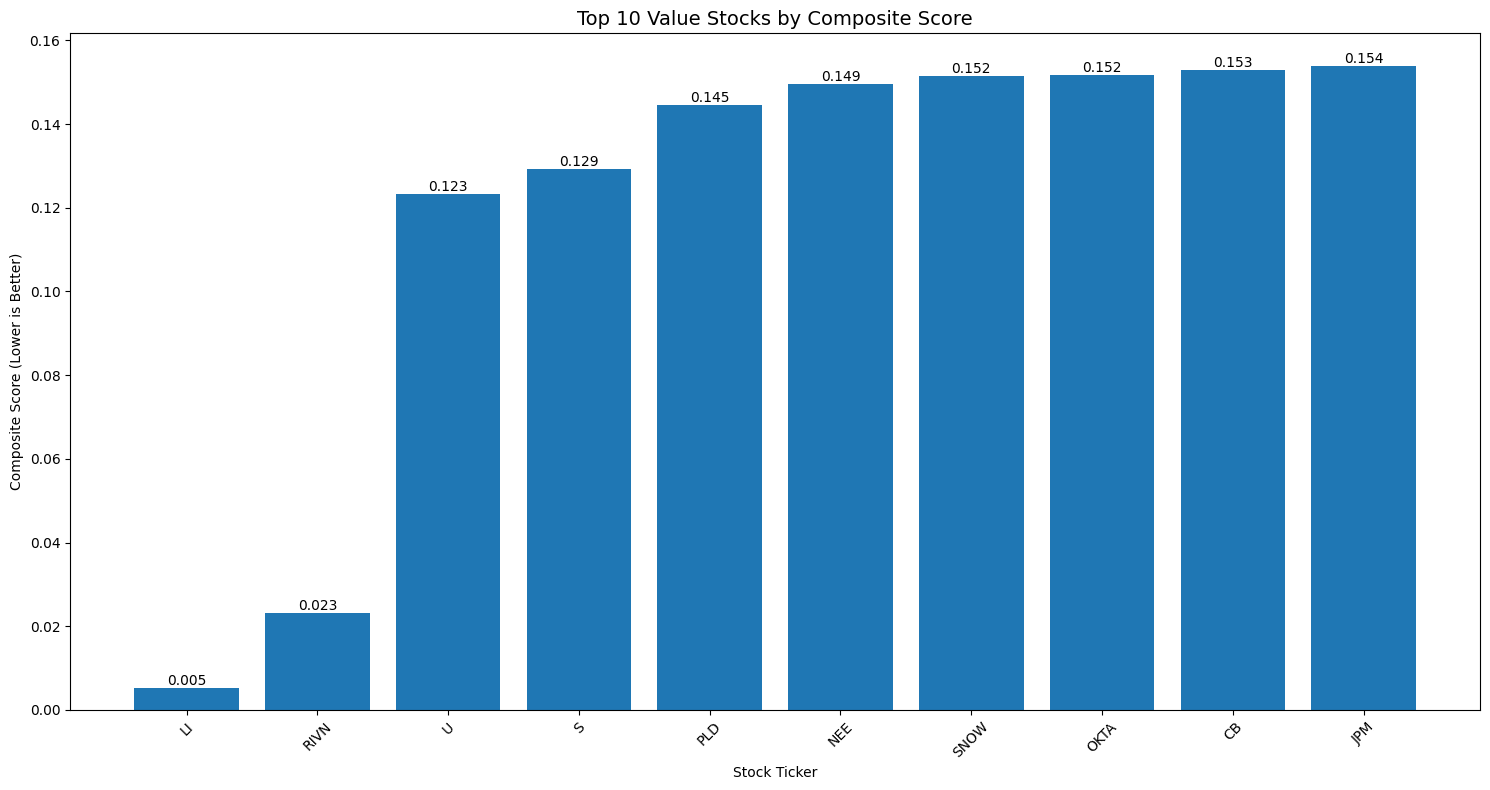

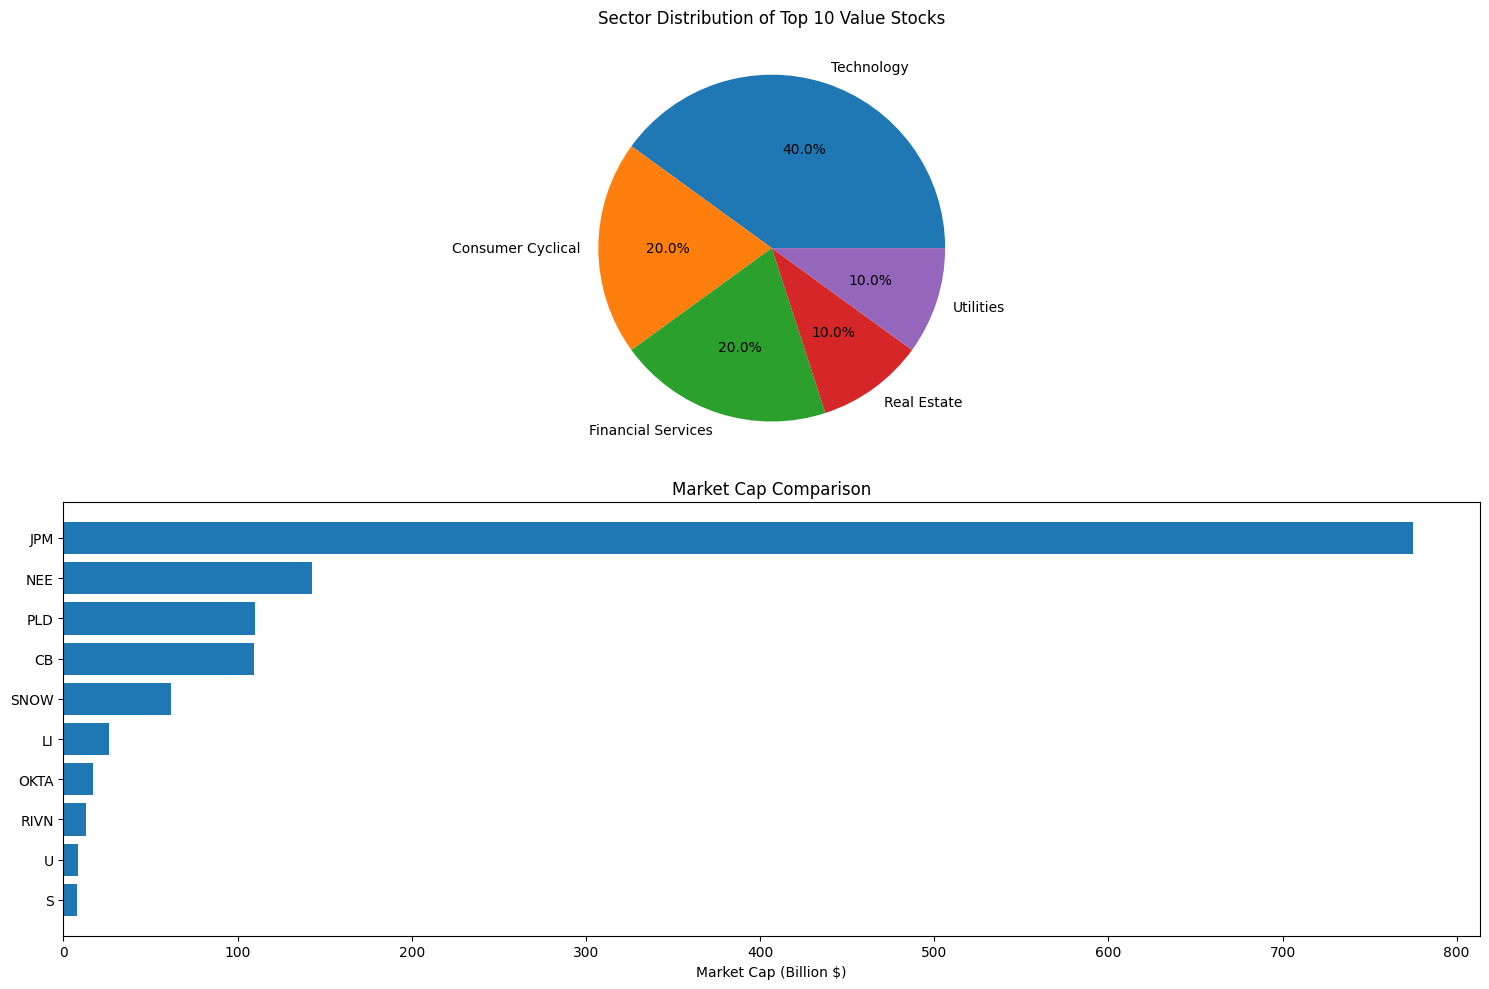

In [8]:
def plot_top_stocks(top_stocks):
    """Plot top 10 stocks by composite score"""
    plt.figure(figsize=(15, 8))
    top_10 = top_stocks.head(10)

    bars = plt.bar(top_10['Ticker'], top_10['Composite_Score'])
    plt.title('Top 10 Value Stocks by Composite Score', fontsize=14)
    plt.xlabel('Stock Ticker')
    plt.ylabel('Composite Score (Lower is Better)')
    plt.xticks(rotation=45)

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def plot_sector_analysis(top_stocks):
    """Plot sector analysis of top stocks"""
    # Get sector data
    sector_data = []
    for ticker in top_stocks.head(10)['Ticker']:
        try:
            stock = yf.Ticker(ticker)
            info = stock.info
            sector_data.append({
                'Ticker': ticker,
                'Sector': info.get('sector', 'Unknown'),
                'Industry': info.get('industry', 'Unknown'),
                'Market_Cap': info.get('marketCap', 0)
            })
        except Exception as e:
            print(f"Error getting data for {ticker}: {str(e)}")

    sector_analysis = pd.DataFrame(sector_data)

    # Create visualization
    plt.figure(figsize=(15, 10))

    # Sector pie chart
    plt.subplot(2, 1, 1)
    sector_counts = sector_analysis['Sector'].value_counts()
    plt.pie(sector_counts, labels=sector_counts.index, autopct='%1.1f%%')
    plt.title('Sector Distribution of Top 10 Value Stocks')

    # Market cap comparison
    plt.subplot(2, 1, 2)
    market_caps = sector_analysis.sort_values('Market_Cap', ascending=True)
    plt.barh(market_caps['Ticker'], market_caps['Market_Cap'] / 1e9)
    plt.xlabel('Market Cap (Billion $)')
    plt.title('Market Cap Comparison')

    plt.tight_layout()
    plt.show()

# Create visualizations
plot_top_stocks(top_stocks)
plot_sector_analysis(top_stocks)

Successfully retrieved data for LI
Successfully retrieved data for RIVN
Successfully retrieved data for U
Successfully retrieved data for S
Successfully retrieved data for PLD
Successfully retrieved data for NEE
Successfully retrieved data for SNOW
Successfully retrieved data for OKTA
Successfully retrieved data for CB
Successfully retrieved data for JPM

Portfolio Metrics:
      Annual Return  Annual Volatility  Sharpe Ratio
LI            0.256              0.594         0.431
RIVN          0.141              0.756         0.187
U             0.088              0.640         0.138
S             0.414              0.580         0.714
PLD           0.086              0.258         0.334
NEE          -0.027              0.272        -0.099
SNOW          0.296              0.538         0.549
OKTA          0.263              0.451         0.584
CB            0.134              0.190         0.706
JPM           0.396              0.219         1.807

Optimal Portfolio Weights:
LI: 8.0%
S: 

<Figure size 1500x800 with 0 Axes>

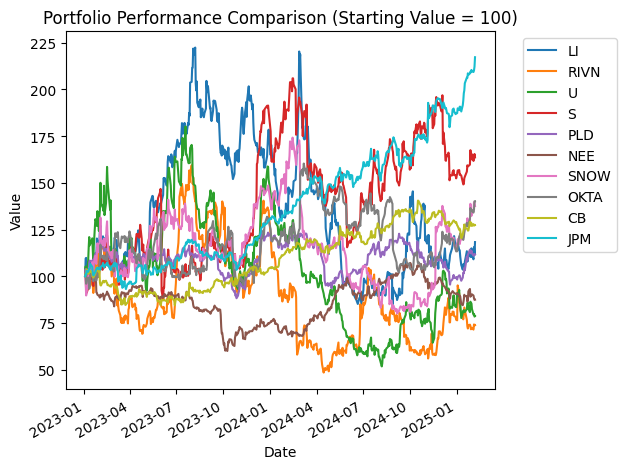

In [9]:
def get_portfolio_data(portfolio_tickers, start_date='2023-01-01'):
    """
    Collect historical price data for portfolio stocks
    """
    historical_prices = pd.DataFrame()

    for ticker in portfolio_tickers:
        try:
            df = yf.download(
                ticker,
                start=start_date,
                progress=False,
                auto_adjust=True
            )

            if not df.empty:
                historical_prices[ticker] = df['Close']
                print(f"Successfully retrieved data for {ticker}")
            else:
                print(f"No data found for {ticker}")

        except Exception as e:
            print(f"Error getting data for {ticker}: {str(e)}")

    return historical_prices.dropna(axis=1, how='all')

def calculate_portfolio_metrics(historical_prices):
    """
    Calculate key portfolio metrics including returns, volatility, and Sharpe ratio
    """
    # Calculate daily returns
    daily_returns = historical_prices.pct_change().dropna()

    # Calculate metrics
    returns = daily_returns.mean() * 252  # Annualized returns
    volatility = daily_returns.std() * np.sqrt(252)  # Annualized volatility
    sharpe = returns / volatility  # Sharpe ratio (assuming 0% risk-free rate for simplicity)

    metrics = pd.DataFrame({
        'Annual Return': returns,
        'Annual Volatility': volatility,
        'Sharpe Ratio': sharpe
    }).round(3)

    return metrics, daily_returns

def optimize_portfolio(daily_returns):
    """
    Optimize portfolio weights using Modern Portfolio Theory
    """
    # Calculate expected returns and covariance matrix
    expected_returns = daily_returns.mean() * 252
    cov_matrix = daily_returns.cov() * 252

    # Define optimization parameters
    n_assets = len(daily_returns.columns)
    bounds = tuple((0, 0.25) for _ in range(n_assets))  # max 25% per stock
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # weights sum to 1

    # Optimization objective (negative Sharpe ratio)
    def neg_sharpe_ratio(weights):
        port_return = np.sum(expected_returns * weights)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -port_return / port_vol

    # Run optimization
    result = minimize(
        neg_sharpe_ratio,
        x0=np.array([1/n_assets] * n_assets),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )

    # Get optimal weights
    optimal_weights = pd.Series(result.x, index=daily_returns.columns)

    # Calculate optimal portfolio metrics
    opt_return = np.sum(expected_returns * optimal_weights)
    opt_vol = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix, optimal_weights)))
    opt_sharpe = opt_return / opt_vol

    return optimal_weights, opt_return, opt_vol, opt_sharpe

def plot_portfolio_performance(historical_prices):
    """
    Plot portfolio performance comparison
    """
    plt.figure(figsize=(15, 8))

    # Normalize to 100
    normalized = 100 * historical_prices / historical_prices.iloc[0]
    normalized.plot()

    plt.title('Portfolio Performance Comparison (Starting Value = 100)')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Run backtesting
portfolio_tickers = top_stocks.head(10)['Ticker'].tolist()
historical_prices = get_portfolio_data(portfolio_tickers)

if not historical_prices.empty:
    # Calculate metrics
    metrics, daily_returns = calculate_portfolio_metrics(historical_prices)
    print("\nPortfolio Metrics:")
    print(metrics)

    # Optimize portfolio
    optimal_weights, opt_return, opt_vol, opt_sharpe = optimize_portfolio(daily_returns)
    print("\nOptimal Portfolio Weights:")
    for ticker, weight in optimal_weights[optimal_weights > 0.01].items():
        print(f"{ticker}: {weight*100:.1f}%")

    print(f"\nOptimal Portfolio Metrics (Annual):")
    print(f"Expected Return: {opt_return*100:.1f}%")
    print(f"Volatility: {opt_vol*100:.1f}%")
    print(f"Sharpe Ratio: {opt_sharpe:.2f}")

    # Plot performance
    plot_portfolio_performance(historical_prices)
else:
    print("No historical data available for backtesting.")

Trying Machine Learning Method



In [12]:
# Add technical indicators to historical data
print("Adding technical indicators...")
for ticker in historical_data:
    try:
        # Add momentum indicators
        historical_data[ticker]['RSI'] = ta.momentum.RSIIndicator(historical_data[ticker]['Close']).rsi()
        historical_data[ticker]['MACD'] = ta.trend.MACD(historical_data[ticker]['Close']).macd()

        # Add trend indicators
        historical_data[ticker]['SMA_20'] = ta.trend.SMAIndicator(historical_data[ticker]['Close'], window=20).sma_indicator()
        historical_data[ticker]['SMA_50'] = ta.trend.SMAIndicator(historical_data[ticker]['Close'], window=50).sma_indicator()

        print(f"Added technical indicators for {ticker}")
    except Exception as e:
        print(f"Error adding technical indicators for {ticker}: {e}")

Adding technical indicators...
Added technical indicators for AAPL
Added technical indicators for MSFT
Added technical indicators for AMZN
Added technical indicators for GOOGL
Added technical indicators for GOOG
Added technical indicators for TSLA
Added technical indicators for V
Added technical indicators for JNJ
Added technical indicators for WMT
Added technical indicators for JPM
Added technical indicators for MA
Added technical indicators for PG
Added technical indicators for UNH
Added technical indicators for NVDA
Added technical indicators for HD
Added technical indicators for DIS
Added technical indicators for PYPL
Added technical indicators for VZ
Added technical indicators for ADBE
Added technical indicators for NFLX
Added technical indicators for INTC
Added technical indicators for CMCSA
Added technical indicators for KO
Added technical indicators for PFE
Added technical indicators for PEP
Added technical indicators for T
Added technical indicators for MRK
Added technical ind

In [16]:
def normalize_score(series):
    """Normalize values to 0-1 range, handling both numpy arrays and pandas series"""
    if isinstance(series, np.ndarray):
        # Handle numpy array
        series = pd.Series(series)

    series = pd.to_numeric(series, errors='coerce')
    series = series.fillna(series.mean())
    min_val = series.min()
    max_val = series.max()

    if min_val == max_val:
        return series * 0
    return (series - min_val) / (max_val - min_val)

def train_multiple_models(X_train, X_test, y_train, y_test, feature_columns):
    """Train multiple models and combine their predictions"""

    # Model 1: Random Forest
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        min_samples_split=5,
        random_state=42
    )
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict_proba(scaled_features)[:, 1]

    # Model 2: Gradient Boosting
    gb_model = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    gb_model.fit(X_train, y_train)
    gb_predictions = gb_model.predict_proba(scaled_features)[:, 1]

    # Combine predictions (simple average)
    combined_predictions = pd.Series((rf_predictions + gb_predictions) / 2)

    # Print model performances
    print("\nModel Performance Comparison:")

    # Random Forest performance
    rf_test_pred = rf_model.predict(X_test)
    print("\nRandom Forest Metrics:")
    print(classification_report(y_test, rf_test_pred))

    # Gradient Boosting performance
    gb_test_pred = gb_model.predict(X_test)
    print("\nGradient Boosting Metrics:")
    print(classification_report(y_test, gb_test_pred))

    # Feature importance for both models
    rf_importance = pd.DataFrame({
        'feature': feature_columns,
        'rf_importance': rf_model.feature_importances_
    })

    gb_importance = pd.DataFrame({
        'feature': feature_columns,
        'gb_importance': gb_model.feature_importances_
    })

    # Combine feature importance
    feature_importance = rf_importance.merge(gb_importance, on='feature')
    feature_importance['avg_importance'] = (
        feature_importance['rf_importance'] +
        feature_importance['gb_importance']
    ) / 2

    return combined_predictions, feature_importance

# Create and scale features
print("\nCreating ML features...")
ml_features = pd.DataFrame()
ml_features['Ticker'] = metrics_df['Ticker']

for ticker in metrics_df['Ticker']:
    try:
        if ticker in historical_data:
            mask = ml_features['Ticker'] == ticker

            # Financial features
            ml_features.loc[mask, 'PE_Ratio'] = metrics_df.loc[
                metrics_df['Ticker'] == ticker, 'PE_Ratio'
            ].values[0]
            ml_features.loc[mask, 'PB_Ratio'] = metrics_df.loc[
                metrics_df['Ticker'] == ticker, 'PB_Ratio'
            ].values[0]
            ml_features.loc[mask, 'Revenue_Growth'] = metrics_df.loc[
                metrics_df['Ticker'] == ticker, 'Revenue_Growth'
            ].values[0]
            ml_features.loc[mask, 'Debt_to_Equity'] = metrics_df.loc[
                metrics_df['Ticker'] == ticker, 'Debt_to_Equity'
            ].values[0]

            # Technical features
            ml_features.loc[mask, 'RSI'] = historical_data[ticker]['RSI'].iloc[-1]
            ml_features.loc[mask, 'MACD'] = historical_data[ticker]['MACD'].iloc[-1]
            ml_features.loc[mask, 'SMA_Ratio'] = (
                historical_data[ticker]['SMA_20'].iloc[-1] /
                historical_data[ticker]['SMA_50'].iloc[-1]
            )

            print(f"Created ML features for {ticker}")
    except Exception as e:
        print(f"Error creating ML features for {ticker}: {e}")

# Prepare features
feature_columns = [
    'PE_Ratio', 'PB_Ratio', 'Revenue_Growth', 'Debt_to_Equity',
    'RSI', 'MACD', 'SMA_Ratio'
]
ml_features = ml_features[feature_columns].fillna(method='ffill')

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(ml_features)

# Prepare target
returns = metrics_df['6M_Return']
median_return = returns.median()
y = (returns > median_return).astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    scaled_features, y, test_size=0.2, random_state=42
)

# Train models and get combined predictions
combined_predictions, feature_importance = train_multiple_models(
    X_train, X_test, y_train, y_test, feature_columns
)

# Add predictions to metrics_df
metrics_df['ML_Score'] = combined_predictions

# Print feature importance analysis
print("\nCombined Feature Importance:")
print(feature_importance.sort_values('avg_importance', ascending=False))

# Update rankings with combined ML predictions
rankings['ML_Rank'] = normalize_score(combined_predictions)
rankings['Final_Score'] = (
    rankings['PE_Rank'].fillna(0) * 0.20 +
    rankings['PB_Rank'].fillna(0) * 0.20 +
    rankings['ROE_Rank'].fillna(0) * 0.15 +
    rankings['Rev_Growth_Rank'].fillna(0) * 0.15 +
    rankings['DE_Rank'].fillna(0) * 0.10 +
    rankings['ML_Rank'].fillna(0) * 0.20
)

# Create final results with combined ML scores
final_results = pd.DataFrame({
    'Ticker': metrics_df['Ticker'],
    'PE_Ratio': metrics_df['PE_Ratio'],
    'PB_Ratio': metrics_df['PB_Ratio'],
    'Revenue_Growth': metrics_df['Revenue_Growth'],
    'ROE': metrics_df['ROE'],
    'ML_Score': combined_predictions,
    'Final_Score': rankings['Final_Score']
}).sort_values('Final_Score')

print("\nTop 10 Stocks (Enhanced ML Ranking):")
print(final_results[['Ticker', 'PE_Ratio', 'PB_Ratio',
                    'Revenue_Growth', 'ROE', 'ML_Score',
                    'Final_Score']].head(10).round(3))


Creating ML features...
Created ML features for AAPL
Created ML features for MSFT
Created ML features for AMZN
Created ML features for GOOGL
Created ML features for GOOG
Created ML features for TSLA
Created ML features for V
Created ML features for JNJ
Created ML features for WMT
Created ML features for JPM
Created ML features for MA
Created ML features for PG
Created ML features for UNH
Created ML features for NVDA
Created ML features for HD
Created ML features for DIS
Created ML features for PYPL
Created ML features for VZ
Created ML features for ADBE
Created ML features for NFLX
Created ML features for INTC
Created ML features for CMCSA
Created ML features for KO
Created ML features for PFE
Created ML features for PEP
Created ML features for T
Created ML features for MRK
Created ML features for ABT
Created ML features for CSCO
Created ML features for XOM
Created ML features for CVX
Created ML features for NKE
Created ML features for LLY
Created ML features for ORCL
Created ML featu

<ipython-input-16-63182ef77ec0>:116: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ml_features = ml_features[feature_columns].fillna(method='ffill')



Model Performance Comparison:

Random Forest Metrics:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        13
           1       0.71      0.80      0.75        15

    accuracy                           0.71        28
   macro avg       0.72      0.71      0.71        28
weighted avg       0.72      0.71      0.71        28


Gradient Boosting Metrics:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67        13
           1       0.71      0.80      0.75        15

    accuracy                           0.71        28
   macro avg       0.72      0.71      0.71        28
weighted avg       0.72      0.71      0.71        28


Combined Feature Importance:
          feature  rf_importance  gb_importance  avg_importance
5            MACD       0.196696       0.254996        0.225846
2  Revenue_Growth       0.176668       0.182670        0.179669
4             RSI       0.200879       0.

In [17]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def evaluate_models_with_cv(X, y, feature_columns):
    """Evaluate models using cross-validation"""

    # Define models with different hyperparameters
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42
    )

    gb_model = GradientBoostingClassifier(
        n_estimators=150,
        learning_rate=0.05,
        max_depth=5,
        min_samples_split=3,
        subsample=0.8,
        random_state=42
    )

    # Create K-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Cross-validation scores for both models
    rf_scores = cross_val_score(rf_model, X, y, cv=kf, scoring='accuracy')
    gb_scores = cross_val_score(gb_model, X, y, cv=kf, scoring='accuracy')

    print("\nCross-Validation Results:")
    print(f"Random Forest CV Scores: {rf_scores}")
    print(f"Random Forest Mean CV Score: {rf_scores.mean():.3f} (+/- {rf_scores.std() * 2:.3f})")
    print(f"\nGradient Boosting CV Scores: {gb_scores}")
    print(f"Gradient Boosting Mean CV Score: {gb_scores.mean():.3f} (+/- {gb_scores.std() * 2:.3f})")

    # Fit models on full training data
    rf_model.fit(X, y)
    gb_model.fit(X, y)

    # Get predictions
    rf_predictions = rf_model.predict_proba(X)[:, 1]
    gb_predictions = gb_model.predict_proba(X)[:, 1]

    # Feature importance
    rf_importance = pd.DataFrame({
        'feature': feature_columns,
        'rf_importance': rf_model.feature_importances_
    })

    gb_importance = pd.DataFrame({
        'feature': feature_columns,
        'gb_importance': gb_model.feature_importances_
    })

    # Calculate prediction differences
    pred_diff = np.abs(rf_predictions - gb_predictions)
    print("\nPrediction Differences:")
    print(f"Mean difference: {pred_diff.mean():.3f}")
    print(f"Max difference: {pred_diff.max():.3f}")
    print(f"Min difference: {pred_diff.min():.3f}")

    # Combine predictions with weighted average based on CV performance
    rf_weight = rf_scores.mean() / (rf_scores.mean() + gb_scores.mean())
    gb_weight = gb_scores.mean() / (rf_scores.mean() + gb_scores.mean())

    combined_predictions = pd.Series(
        rf_predictions * rf_weight + gb_predictions * gb_weight
    )

    return combined_predictions, rf_importance, gb_importance, rf_model, gb_model

# Run enhanced evaluation
combined_predictions, rf_importance, gb_importance, rf_model, gb_model = \
    evaluate_models_with_cv(scaled_features, y, feature_columns)

# Print feature importance differences
feature_comparison = rf_importance.merge(gb_importance, on='feature')
feature_comparison['importance_diff'] = abs(
    feature_comparison['rf_importance'] - feature_comparison['gb_importance']
)

print("\nFeature Importance Differences:")
print(feature_comparison.sort_values('importance_diff', ascending=False))


Cross-Validation Results:
Random Forest CV Scores: [0.78571429 0.64285714 0.57142857 0.64285714 0.71428571]
Random Forest Mean CV Score: 0.671 (+/- 0.146)

Gradient Boosting CV Scores: [0.67857143 0.57142857 0.57142857 0.60714286 0.71428571]
Gradient Boosting Mean CV Score: 0.629 (+/- 0.116)

Prediction Differences:
Mean difference: 0.187
Max difference: 0.519
Min difference: 0.016

Feature Importance Differences:
          feature  rf_importance  gb_importance  importance_diff
5            MACD       0.195911       0.281408         0.085498
6       SMA_Ratio       0.158192       0.119016         0.039176
1        PB_Ratio       0.099319       0.060928         0.038391
4             RSI       0.173420       0.147801         0.025619
3  Debt_to_Equity       0.114583       0.127849         0.013266
2  Revenue_Growth       0.150474       0.159933         0.009460
0        PE_Ratio       0.108102       0.103064         0.005038


In [18]:
def add_enhanced_technical_indicators(historical_data):
    """Add more technical indicators to historical price data"""
    for ticker in historical_data:
        try:
            close_prices = historical_data[ticker]['Close']
            high_prices = historical_data[ticker]['High']
            low_prices = historical_data[ticker]['Low']
            volume = historical_data[ticker]['Volume']

            # Existing indicators
            historical_data[ticker]['RSI'] = ta.momentum.RSIIndicator(close_prices).rsi()
            historical_data[ticker]['MACD'] = ta.trend.MACD(close_prices).macd()
            historical_data[ticker]['MACD_Signal'] = ta.trend.MACD(close_prices).macd_signal()
            historical_data[ticker]['MACD_Diff'] = ta.trend.MACD(close_prices).macd_diff()

            # Moving averages
            historical_data[ticker]['SMA_20'] = ta.trend.SMAIndicator(close_prices, window=20).sma_indicator()
            historical_data[ticker]['SMA_50'] = ta.trend.SMAIndicator(close_prices, window=50).sma_indicator()

            # New indicators
            # Bollinger Bands
            bollinger = ta.volatility.BollingerBands(close_prices)
            historical_data[ticker]['BB_High'] = bollinger.bollinger_hband()
            historical_data[ticker]['BB_Low'] = bollinger.bollinger_lband()
            historical_data[ticker]['BB_Width'] = (
                (historical_data[ticker]['BB_High'] - historical_data[ticker]['BB_Low']) /
                historical_data[ticker]['SMA_20']
            )

            # Volatility
            historical_data[ticker]['ATR'] = ta.volatility.AverageTrueRange(
                high_prices, low_prices, close_prices
            ).average_true_range()

            # Volume indicators
            historical_data[ticker]['OBV'] = ta.volume.OnBalanceVolumeIndicator(
                close_prices, volume
            ).on_balance_volume()

            # Momentum
            historical_data[ticker]['ROC'] = ta.momentum.ROCIndicator(close_prices).roc()
            historical_data[ticker]['Stoch'] = ta.momentum.StochasticOscillator(
                high_prices, low_prices, close_prices
            ).stoch()

            print(f"Added enhanced indicators for {ticker}")

        except Exception as e:
            print(f"Error adding indicators for {ticker}: {e}")

    return historical_data

def create_enhanced_ml_features(metrics_df, historical_data):
    """Create enhanced feature set for ML"""
    ml_features = pd.DataFrame()
    ml_features['Ticker'] = metrics_df['Ticker']

    for ticker in metrics_df['Ticker']:
        try:
            if ticker in historical_data:
                mask = ml_features['Ticker'] == ticker

                # Financial features
                ml_features.loc[mask, 'PE_Ratio'] = metrics_df.loc[
                    metrics_df['Ticker'] == ticker, 'PE_Ratio'
                ].values[0]
                ml_features.loc[mask, 'PB_Ratio'] = metrics_df.loc[
                    metrics_df['Ticker'] == ticker, 'PB_Ratio'
                ].values[0]
                ml_features.loc[mask, 'Revenue_Growth'] = metrics_df.loc[
                    metrics_df['Ticker'] == ticker, 'Revenue_Growth'
                ].values[0]
                ml_features.loc[mask, 'Debt_to_Equity'] = metrics_df.loc[
                    metrics_df['Ticker'] == ticker, 'Debt_to_Equity'
                ].values[0]

                # Technical features - use last value for each indicator
                tech_data = historical_data[ticker]
                ml_features.loc[mask, 'RSI'] = tech_data['RSI'].iloc[-1]
                ml_features.loc[mask, 'MACD'] = tech_data['MACD'].iloc[-1]
                ml_features.loc[mask, 'MACD_Signal'] = tech_data['MACD_Signal'].iloc[-1]
                ml_features.loc[mask, 'MACD_Diff'] = tech_data['MACD_Diff'].iloc[-1]
                ml_features.loc[mask, 'BB_Width'] = tech_data['BB_Width'].iloc[-1]
                ml_features.loc[mask, 'ATR'] = tech_data['ATR'].iloc[-1]
                ml_features.loc[mask, 'ROC'] = tech_data['ROC'].iloc[-1]
                ml_features.loc[mask, 'Stoch'] = tech_data['Stoch'].iloc[-1]

                # Trend features
                ml_features.loc[mask, 'SMA_Ratio'] = (
                    tech_data['SMA_20'].iloc[-1] / tech_data['SMA_50'].iloc[-1]
                )

                # Volume trend
                ml_features.loc[mask, 'OBV_Change'] = (
                    tech_data['OBV'].iloc[-1] / tech_data['OBV'].iloc[-20] - 1
                )

                print(f"Created enhanced features for {ticker}")

        except Exception as e:
            print(f"Error creating features for {ticker}: {e}")

    return ml_features.drop('Ticker', axis=1)

# Update the data with new features
historical_data = add_enhanced_technical_indicators(historical_data)
ml_features = create_enhanced_ml_features(metrics_df, historical_data)

# Scale the new features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(ml_features)

# Retrain models with new features
print("\nRetraining models with enhanced features...")
combined_predictions, rf_importance, gb_importance, rf_model, gb_model = \
    evaluate_models_with_cv(scaled_features, y, ml_features.columns)

Added enhanced indicators for AAPL
Added enhanced indicators for MSFT
Added enhanced indicators for AMZN
Added enhanced indicators for GOOGL
Added enhanced indicators for GOOG
Added enhanced indicators for TSLA
Added enhanced indicators for V
Added enhanced indicators for JNJ
Added enhanced indicators for WMT
Added enhanced indicators for JPM
Added enhanced indicators for MA
Added enhanced indicators for PG
Added enhanced indicators for UNH
Added enhanced indicators for NVDA
Added enhanced indicators for HD
Added enhanced indicators for DIS
Added enhanced indicators for PYPL
Added enhanced indicators for VZ
Added enhanced indicators for ADBE
Added enhanced indicators for NFLX
Added enhanced indicators for INTC
Added enhanced indicators for CMCSA
Added enhanced indicators for KO
Added enhanced indicators for PFE
Added enhanced indicators for PEP
Added enhanced indicators for T
Added enhanced indicators for MRK
Added enhanced indicators for ABT
Added enhanced indicators for CSCO
Added en

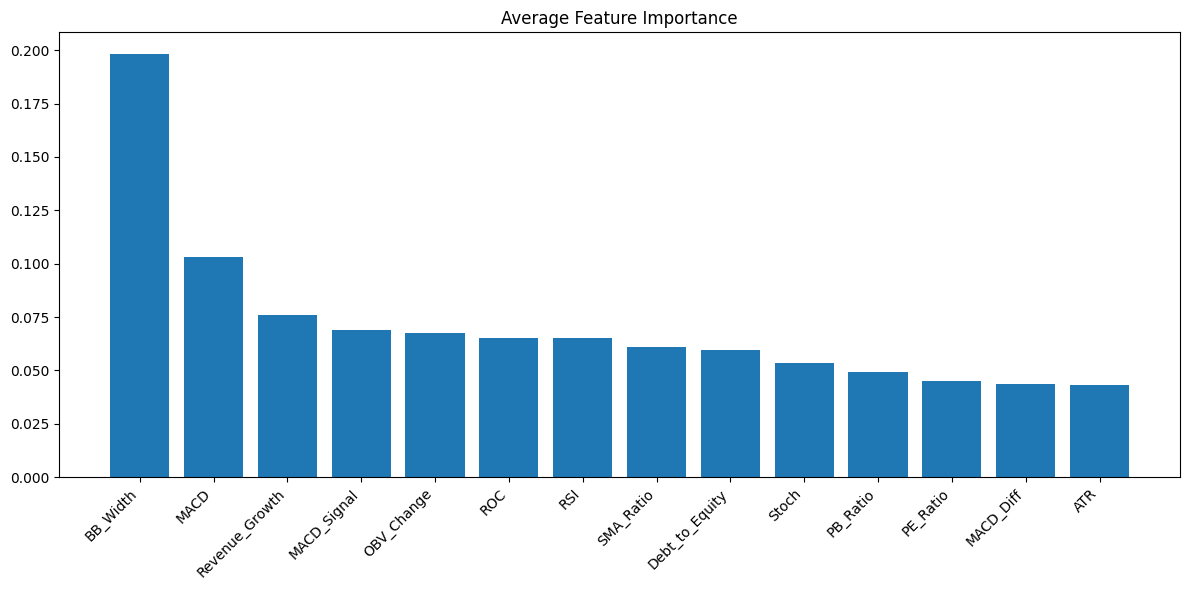


Top 5 Most Important Features:
           Feature  RF_Importance  GB_Importance  Avg_Importance
8         BB_Width       0.142547       0.254430        0.198488
5             MACD       0.098492       0.108078        0.103285
2   Revenue_Growth       0.078921       0.073203        0.076062
6      MACD_Signal       0.102240       0.035651        0.068946
13      OBV_Change       0.055447       0.079244        0.067346

Bottom 5 Features:
      Feature  RF_Importance  GB_Importance  Avg_Importance
11      Stoch       0.063309       0.043358        0.053334
1    PB_Ratio       0.047722       0.050861        0.049291
0    PE_Ratio       0.050146       0.039485        0.044816
7   MACD_Diff       0.047817       0.039868        0.043842
9         ATR       0.040207       0.046453        0.043330

Highly Correlated Features (correlation > 0.8):
RSI - Stoch: 0.894
MACD - MACD_Signal: 0.957


In [19]:
def analyze_feature_importance(rf_model, gb_model, feature_names):
    """Analyze and visualize feature importance from both models"""
    # Combine feature importance
    feature_importance = pd.DataFrame({
        'Feature': feature_names,
        'RF_Importance': rf_model.feature_importances_,
        'GB_Importance': gb_model.feature_importances_,
        'Avg_Importance': (rf_model.feature_importances_ + gb_model.feature_importances_) / 2
    })

    # Sort by average importance
    feature_importance = feature_importance.sort_values('Avg_Importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(feature_importance)), feature_importance['Avg_Importance'])
    plt.xticks(range(len(feature_importance)), feature_importance['Feature'], rotation=45, ha='right')
    plt.title('Average Feature Importance')
    plt.tight_layout()
    plt.show()

    # Print detailed analysis
    print("\nTop 5 Most Important Features:")
    print(feature_importance.head())

    print("\nBottom 5 Features:")
    print(feature_importance.tail())

    return feature_importance

# Analyze feature importance
importance_analysis = analyze_feature_importance(rf_model, gb_model, ml_features.columns)

# Calculate correlation between features
correlation_matrix = ml_features.corr()

# Find highly correlated features
threshold = 0.8
high_correlation = np.where(np.abs(correlation_matrix) > threshold)
high_correlation = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x, y])
                   for x, y in zip(*high_correlation) if x != y and x < y]

if high_correlation:
    print("\nHighly Correlated Features (correlation > 0.8):")
    for feat1, feat2, corr in high_correlation:
        print(f"{feat1} - {feat2}: {corr:.3f}")

In [20]:
from sklearn.ensemble import BaggingClassifier

def create_regularized_ensemble(X, y):
    """Create a more robust ensemble with regularization"""

    # Base Random Forest with regularization
    rf_base = RandomForestClassifier(
        n_estimators=100,
        max_depth=6,
        min_samples_split=5,
        min_samples_leaf=3,
        max_features='sqrt',
        random_state=42
    )

    # Bagging to reduce variance
    rf_bagging = BaggingClassifier(
        rf_base,
        n_estimators=10,
        max_samples=0.8,
        max_features=0.8,
        random_state=42
    )

    # Base Gradient Boosting with regularization
    gb_base = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.05,
        max_depth=4,
        min_samples_split=5,
        subsample=0.8,
        random_state=42
    )

    # Train models
    rf_bagging.fit(X, y)
    gb_base.fit(X, y)

    # Get predictions
    rf_pred = rf_bagging.predict_proba(X)[:, 1]
    gb_pred = gb_base.predict_proba(X)[:, 1]

    # Combine predictions with stability weighting
    combined_pred = 0.6 * rf_pred + 0.4 * gb_pred

    return pd.Series(combined_pred), rf_bagging, gb_base

# Create regularized ensemble
print("\nTraining regularized ensemble...")
reg_predictions, reg_rf, reg_gb = create_regularized_ensemble(scaled_features, y)

# Evaluate regularized ensemble
kf = KFold(n_splits=5, shuffle=True, random_state=42)
reg_scores = cross_val_score(reg_rf, scaled_features, y, cv=kf)

print("\nRegularized Ensemble CV Scores:", reg_scores)
print(f"Mean CV Score: {reg_scores.mean():.3f} (+/- {reg_scores.std() * 2:.3f})")

# Compare prediction stability
print("\nPrediction Stability Analysis:")
print(f"Original prediction std: {combined_predictions.std():.3f}")
print(f"Regularized prediction std: {reg_predictions.std():.3f}")


Training regularized ensemble...

Regularized Ensemble CV Scores: [0.85714286 0.57142857 0.57142857 0.71428571 0.82142857]
Mean CV Score: 0.707 (+/- 0.241)

Prediction Stability Analysis:
Original prediction std: 0.396
Regularized prediction std: 0.303


<ipython-input-21-a580dc171edc>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_stocks['Recommended_Weight'] = top_stocks['Risk_Adjusted_Score'] / total_score



Trading Strategy Summary:

Top 10 Recommended Positions:
   Ticker  ML_Score Position_Size  Volatility  Risk_Adjusted_Score  \
6       V     0.925         Large       0.160                0.940   
60     GE     0.936         Large       0.274                0.917   
10     MA     0.874         Large       0.165                0.903   
51    IBM     0.885         Large       0.219                0.896   
67    SYK     0.873         Large       0.199                0.893   
19   NFLX     0.911         Large       0.337                0.883   
39    ACN     0.870         Large       0.230                0.883   
36   COST     0.851         Large       0.183                0.882   
9     JPM     0.863         Large       0.221                0.880   
59   ISRG     0.879         Large       0.276                0.876   

    Recommended_Weight  
6                0.105  
60               0.102  
10               0.101  
51               0.100  
67               0.100  
19               0.09

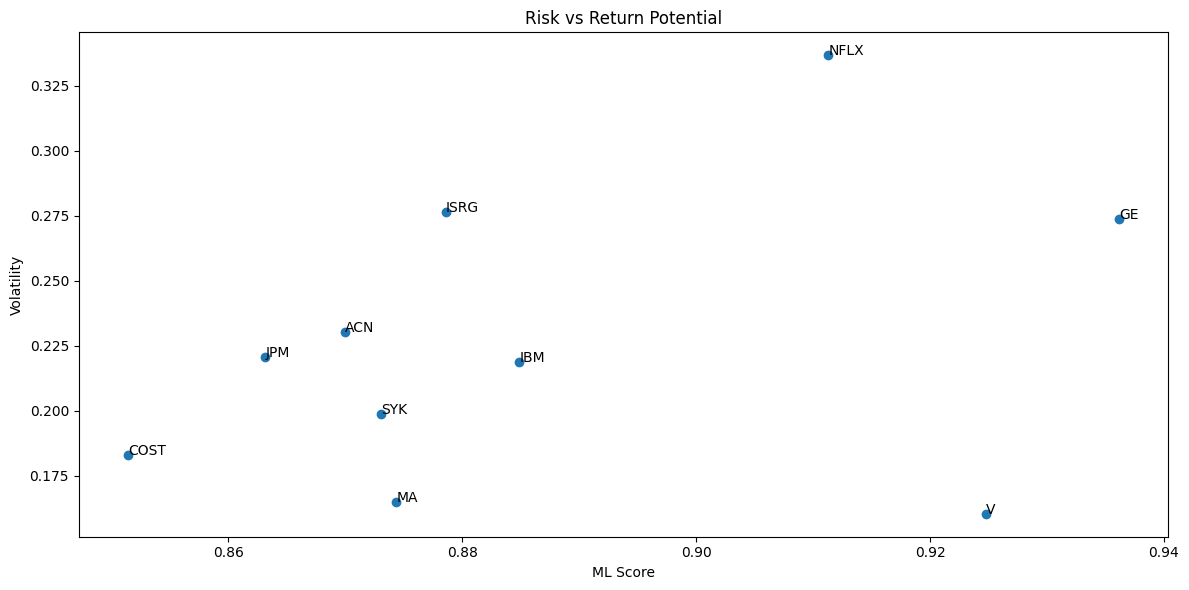

In [21]:
def create_trading_strategy(reg_predictions, metrics_df, historical_data):
    """Create a trading strategy based on ML predictions and risk management"""

    # Create strategy DataFrame
    strategy_df = pd.DataFrame({
        'Ticker': metrics_df['Ticker'],
        'ML_Score': reg_predictions,
        'PE_Ratio': metrics_df['PE_Ratio'],
        'PB_Ratio': metrics_df['PB_Ratio'],
        'Revenue_Growth': metrics_df['Revenue_Growth'],
        'ROE': metrics_df['ROE']
    })

    # Calculate volatility for each stock
    volatilities = {}
    for ticker in strategy_df['Ticker']:
        if ticker in historical_data:
            returns = historical_data[ticker]['Close'].pct_change()
            volatilities[ticker] = returns.std() * np.sqrt(252)  # Annualized volatility

    strategy_df['Volatility'] = strategy_df['Ticker'].map(volatilities)

    # Score-based position sizing
    def get_position_size(row):
        if row['ML_Score'] > 0.7:  # High conviction
            return 'Large'
        elif row['ML_Score'] > 0.6:  # Medium conviction
            return 'Medium'
        elif row['ML_Score'] > 0.5:  # Low conviction
            return 'Small'
        else:
            return 'Avoid'

    strategy_df['Position_Size'] = strategy_df.apply(get_position_size, axis=1)

    # Risk-adjusted portfolio construction
    def get_risk_score(row):
        vol_score = 1 - (row['Volatility'] - strategy_df['Volatility'].min()) / \
                   (strategy_df['Volatility'].max() - strategy_df['Volatility'].min())
        return row['ML_Score'] * 0.7 + vol_score * 0.3

    strategy_df['Risk_Adjusted_Score'] = strategy_df.apply(get_risk_score, axis=1)

    # Sort by risk-adjusted score
    strategy_df = strategy_df.sort_values('Risk_Adjusted_Score', ascending=False)

    # Calculate recommended portfolio weights
    top_n = 10  # Top 10 stocks
    top_stocks = strategy_df.head(top_n)

    total_score = top_stocks['Risk_Adjusted_Score'].sum()
    top_stocks['Recommended_Weight'] = top_stocks['Risk_Adjusted_Score'] / total_score

    print("\nTrading Strategy Summary:")
    print(f"\nTop {top_n} Recommended Positions:")
    summary = top_stocks[['Ticker', 'ML_Score', 'Position_Size',
                         'Volatility', 'Risk_Adjusted_Score',
                         'Recommended_Weight']]
    print(summary.round(3))

    # Portfolio risk metrics
    print("\nPortfolio Risk Metrics:")
    print(f"Average Volatility: {top_stocks['Volatility'].mean():.2%}")
    print(f"Average ML Score: {top_stocks['ML_Score'].mean():.3f}")

    # Create visualization
    plt.figure(figsize=(12, 6))
    plt.scatter(top_stocks['ML_Score'], top_stocks['Volatility'])
    plt.xlabel('ML Score')
    plt.ylabel('Volatility')
    plt.title('Risk vs Return Potential')

    # Add ticker labels
    for _, row in top_stocks.iterrows():
        plt.annotate(row['Ticker'],
                    (row['ML_Score'], row['Volatility']))

    plt.tight_layout()
    plt.show()

    return strategy_df

# Create and analyze trading strategy
strategy_results = create_trading_strategy(reg_predictions, metrics_df, historical_data)


Current Sector Exposure:
Sector
Financial Services        3
Technology                2
Healthcare                2
Industrials               1
Communication Services    1
Consumer Defensive        1
Name: count, dtype: int64

Diversified Portfolio Summary:

Sector Weights:
Sector
Communication Services    0.10
Consumer Defensive        0.15
Financial Services        0.25
Healthcare                0.20
Industrials               0.10
Technology                0.20
Name: Weight, dtype: float64

Detailed Portfolio:
   Ticker                  Sector  ML_Score  Volatility  Weight  \
0       V      Financial Services     0.925       0.160    0.10   
1      GE             Industrials     0.936       0.274    0.10   
2      MA      Financial Services     0.874       0.165    0.10   
3     IBM              Technology     0.885       0.219    0.10   
4     SYK              Healthcare     0.873       0.199    0.10   
5    NFLX  Communication Services     0.911       0.337    0.10   
6     ACN   

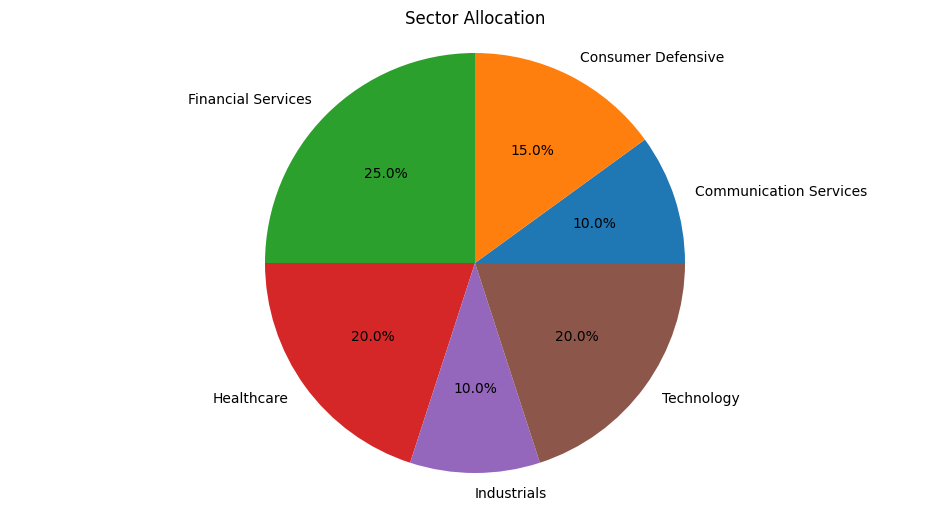

In [23]:
def create_diversified_strategy(strategy_df, historical_data):
    """Create a sector-diversified trading strategy"""

    # Calculate initial weights based on Risk_Adjusted_Score
    total_score = strategy_df['Risk_Adjusted_Score'].sum()
    strategy_df['Recommended_Weight'] = strategy_df['Risk_Adjusted_Score'] / total_score

    # Get sector information
    sector_info = {}
    for ticker in strategy_df['Ticker']:
        try:
            stock = yf.Ticker(ticker)
            sector_info[ticker] = stock.info.get('sector', 'Unknown')
        except:
            sector_info[ticker] = 'Unknown'

    strategy_df['Sector'] = strategy_df['Ticker'].map(sector_info)

    # Calculate sector exposures of top stocks
    sector_exposure = strategy_df.head(10)['Sector'].value_counts()
    print("\nCurrent Sector Exposure:")
    print(sector_exposure)

    # Implement sector constraints
    def get_diversified_portfolio(df, max_sector_weight=0.25):
        portfolio = []
        sector_weights = {}
        total_weight = 0

        # Sort by Risk_Adjusted_Score to get best stocks first
        for _, row in df.sort_values('Risk_Adjusted_Score', ascending=False).iterrows():
            sector = row['Sector']
            current_sector_weight = sector_weights.get(sector, 0)

            # Check if we can add this stock
            if current_sector_weight < max_sector_weight and total_weight < 1:
                # Calculate weight considering constraints
                base_weight = 0.10  # Start with 10% position size
                available_sector_weight = max_sector_weight - current_sector_weight
                available_total_weight = 1 - total_weight

                # Take the minimum weight that satisfies all constraints
                weight = min(base_weight,
                           available_sector_weight,
                           available_total_weight)

                if weight > 0.01:  # Minimum position size of 1%
                    portfolio.append({
                        'Ticker': row['Ticker'],
                        'Sector': sector,
                        'ML_Score': row['ML_Score'],
                        'Volatility': row['Volatility'],
                        'Risk_Adjusted_Score': row['Risk_Adjusted_Score'],
                        'Weight': weight
                    })

                    sector_weights[sector] = current_sector_weight + weight
                    total_weight += weight

            if total_weight >= 0.99:  # Allow for small rounding differences
                break

        return pd.DataFrame(portfolio)

    # Get diversified portfolio
    diversified_portfolio = get_diversified_portfolio(strategy_df)

    # Normalize weights to ensure they sum to 1
    diversified_portfolio['Weight'] = diversified_portfolio['Weight'] / diversified_portfolio['Weight'].sum()

    # Calculate portfolio metrics
    print("\nDiversified Portfolio Summary:")
    summary = diversified_portfolio.groupby('Sector')['Weight'].sum()
    print("\nSector Weights:")
    print(summary.round(3))

    print("\nDetailed Portfolio:")
    print(diversified_portfolio[['Ticker', 'Sector', 'ML_Score',
                                'Volatility', 'Weight',
                                'Risk_Adjusted_Score']].round(3))

    # Calculate risk metrics
    portfolio_vol = np.sqrt(np.sum(diversified_portfolio['Weight'] *
                                 diversified_portfolio['Volatility']) ** 2)
    weighted_ml_score = (diversified_portfolio['ML_Score'] *
                        diversified_portfolio['Weight']).sum()

    print("\nPortfolio Risk Metrics:")
    print(f"Portfolio Volatility: {portfolio_vol:.2%}")
    print(f"Weighted ML Score: {weighted_ml_score:.3f}")

    # Visualize sector allocation
    plt.figure(figsize=(12, 6))
    plt.pie(summary, labels=summary.index, autopct='%1.1f%%')
    plt.title('Sector Allocation')
    plt.axis('equal')
    plt.show()

    return diversified_portfolio

# Create diversified portfolio
diversified_results = create_diversified_strategy(strategy_results, historical_data)

Comparision



Portfolio Comparison:

Stock Selection Overlap:
  Traditional_Top_10 ML_Enhanced_Top_10
0                 LI                 LI
1               RIVN               RIVN
2                  U                USB
3                  S                 CB
4                PLD              CMCSA
5                NEE               REGN
6               SNOW                 VZ
7               OKTA                XOM
8                 CB                CAT
9                JPM                NIO

Overlap between Traditional and ML Rankings: 30.0%

Portfolio Metrics Comparison:
                Traditional  ML_Enhanced
Avg_PE               23.990       16.599
Avg_PB                3.360        2.284
Avg_Rev_Growth        0.608        0.390
Avg_ROE                 NaN          NaN

Performance Metrics:
               Traditional  ML_Enhanced
Annual_Return        0.151        0.055
Annual_Vol           0.244        0.208
Sharpe_Ratio         0.617        0.264
Max_Drawdown        -0.242       -0.167


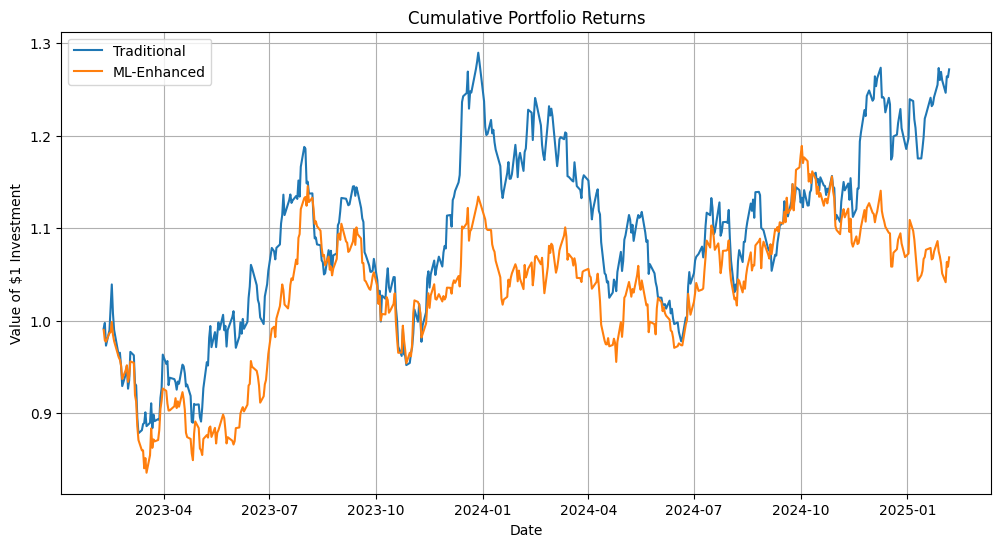

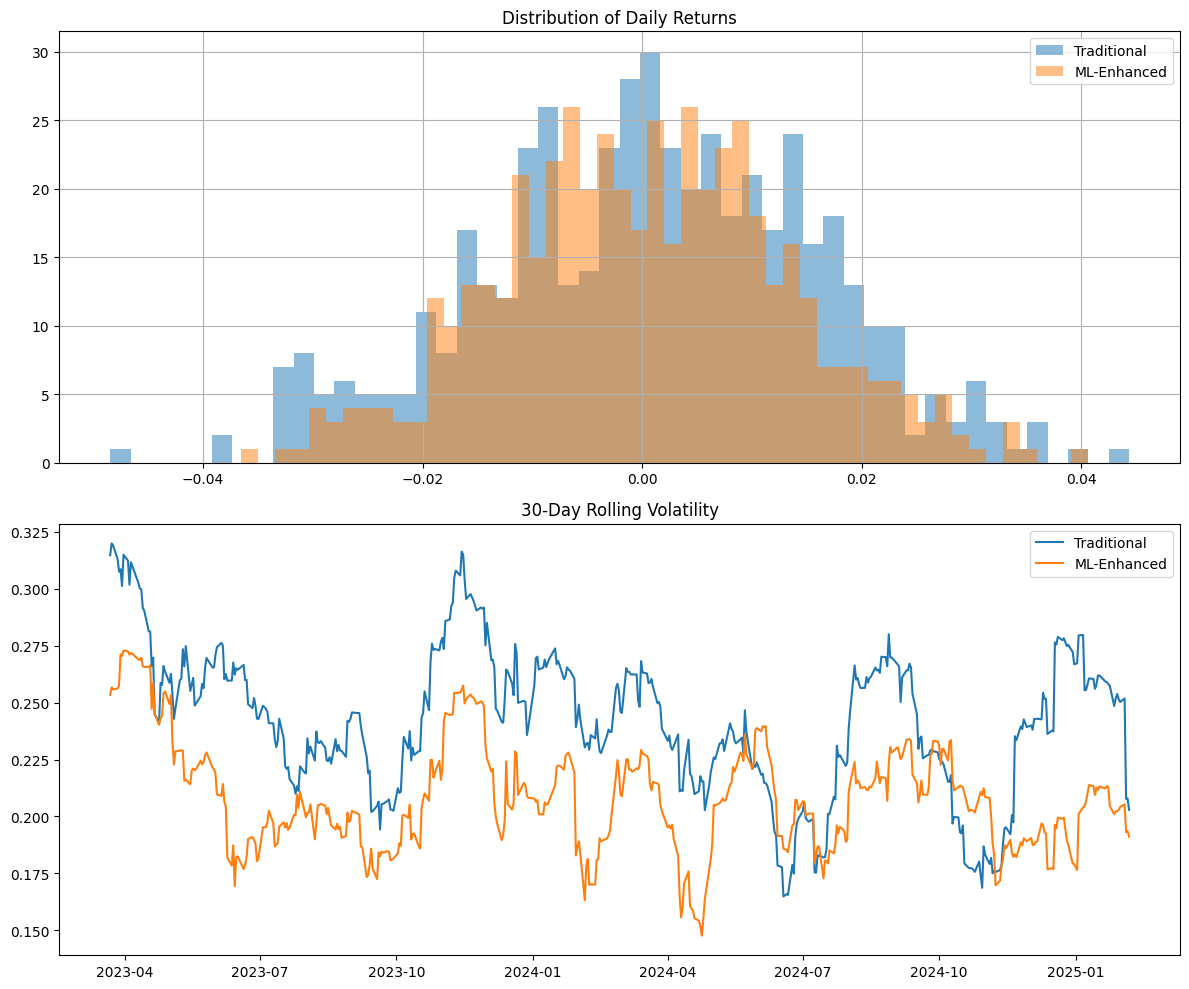

In [24]:
def compare_portfolios(traditional_portfolio, ml_portfolio, metrics_df, historical_data):
    """Compare traditional and ML-enhanced portfolios"""

    # Create comparison DataFrame
    comparison = pd.DataFrame({
        'Traditional_Top_10': traditional_portfolio['Ticker'].head(10).values,
        'ML_Enhanced_Top_10': ml_portfolio['Ticker'].head(10).values
    })

    # Calculate overlap
    overlap = len(set(comparison['Traditional_Top_10']) &
                 set(comparison['ML_Enhanced_Top_10']))

    print("\nPortfolio Comparison:")
    print("\nStock Selection Overlap:")
    print(comparison)
    print(f"\nOverlap between Traditional and ML Rankings: {(overlap/10)*100:.1f}%")

    # Compare key metrics
    def get_portfolio_metrics(tickers):
        portfolio_metrics = metrics_df[metrics_df['Ticker'].isin(tickers)]
        metrics = {
            'Avg_PE': portfolio_metrics['PE_Ratio'].mean(),
            'Avg_PB': portfolio_metrics['PB_Ratio'].mean(),
            'Avg_Rev_Growth': portfolio_metrics['Revenue_Growth'].mean(),
            'Avg_ROE': portfolio_metrics['ROE'].mean()
        }
        return metrics

    trad_metrics = get_portfolio_metrics(comparison['Traditional_Top_10'])
    ml_metrics = get_portfolio_metrics(comparison['ML_Enhanced_Top_10'])

    print("\nPortfolio Metrics Comparison:")
    metrics_comparison = pd.DataFrame({
        'Traditional': trad_metrics,
        'ML_Enhanced': ml_metrics
    }).round(3)
    print(metrics_comparison)

    # Calculate historical performance
    def calculate_portfolio_performance(tickers, start_date='2023-01-01'):
        portfolio_returns = pd.DataFrame()

        for ticker in tickers:
            if ticker in historical_data:
                prices = historical_data[ticker]['Close']
                returns = prices.pct_change()
                portfolio_returns[ticker] = returns

        # Equal-weighted portfolio returns
        portfolio_returns['Portfolio'] = portfolio_returns.mean(axis=1)
        return portfolio_returns

    trad_returns = calculate_portfolio_performance(comparison['Traditional_Top_10'])
    ml_returns = calculate_portfolio_performance(comparison['ML_Enhanced_Top_10'])

    # Calculate performance metrics
    def get_performance_metrics(returns):
        metrics = {
            'Annual_Return': returns['Portfolio'].mean() * 252,
            'Annual_Vol': returns['Portfolio'].std() * np.sqrt(252),
            'Sharpe_Ratio': (returns['Portfolio'].mean() * 252) /
                           (returns['Portfolio'].std() * np.sqrt(252)),
            'Max_Drawdown': (1 + returns['Portfolio']).cumprod().div(
                (1 + returns['Portfolio']).cumprod().cummax()
            ).min() - 1
        }
        return metrics

    trad_perf = get_performance_metrics(trad_returns)
    ml_perf = get_performance_metrics(ml_returns)

    print("\nPerformance Metrics:")
    perf_comparison = pd.DataFrame({
        'Traditional': trad_perf,
        'ML_Enhanced': ml_perf
    }).round(3)
    print(perf_comparison)

    # Visualize cumulative returns
    plt.figure(figsize=(12, 6))
    cumul_trad = (1 + trad_returns['Portfolio']).cumprod()
    cumul_ml = (1 + ml_returns['Portfolio']).cumprod()

    plt.plot(cumul_trad, label='Traditional')
    plt.plot(cumul_ml, label='ML-Enhanced')
    plt.title('Cumulative Portfolio Returns')
    plt.xlabel('Date')
    plt.ylabel('Value of $1 Investment')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Risk analysis visualization
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Distribution of returns
    trad_returns['Portfolio'].hist(bins=50, alpha=0.5, label='Traditional',
                                 ax=axes[0])
    ml_returns['Portfolio'].hist(bins=50, alpha=0.5, label='ML-Enhanced',
                               ax=axes[0])
    axes[0].set_title('Distribution of Daily Returns')
    axes[0].legend()

    # Rolling volatility
    window = 30
    trad_vol = trad_returns['Portfolio'].rolling(window).std() * np.sqrt(252)
    ml_vol = ml_returns['Portfolio'].rolling(window).std() * np.sqrt(252)

    axes[1].plot(trad_vol, label='Traditional')
    axes[1].plot(ml_vol, label='ML-Enhanced')
    axes[1].set_title(f'{window}-Day Rolling Volatility')
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return comparison, metrics_comparison, perf_comparison

# Run comparison
comparison_results = compare_portfolios(top_stocks, final_results, metrics_df, historical_data)


Hybrid Portfolio Selection:
   Ticker  Annual_Return  Volatility  Revenue_Growth  PE_Ratio  \
3      CB          0.152       0.185           0.157    12.123   
4     JPM          0.380       0.221           0.205    14.027   
15     VZ          0.085       0.219          -0.021     9.647   
11    XOM          0.028       0.219          -0.160    13.813   
13   REGN         -0.006       0.230           0.083    18.833   
5     PLD          0.015       0.255           0.343    35.813   
16    NEE          0.018       0.269           0.342    20.555   
0     CAT          0.247       0.276           0.128    16.589   
8   CMCSA         -0.010       0.248           0.018     8.326   
12     LI          0.160       0.590           1.735    18.519   

    In_Traditional  In_ML  Hybrid_Score  
3             True   True         1.732  
4             True  False         1.572  
15           False   True         1.396  
11           False   True         1.335  
13           False   True         

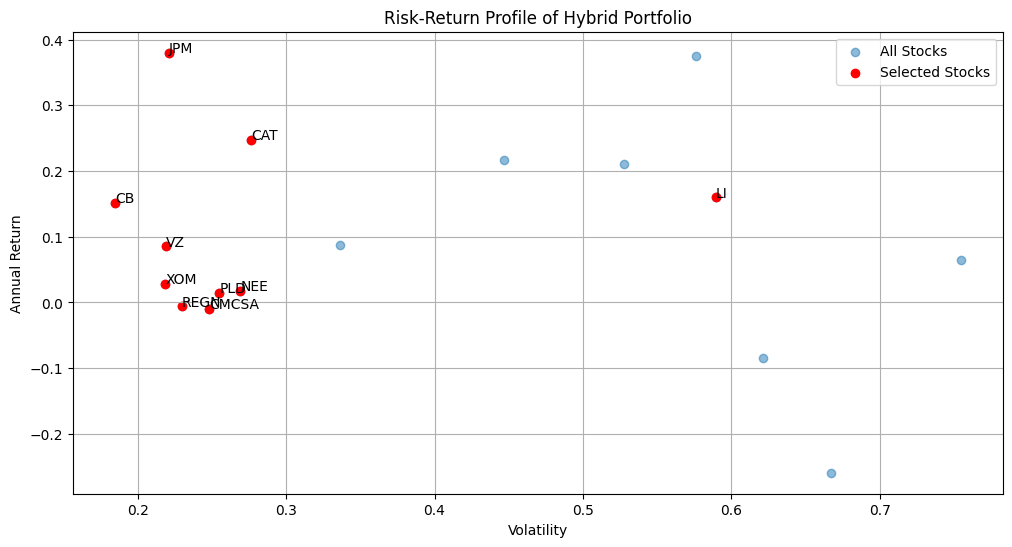

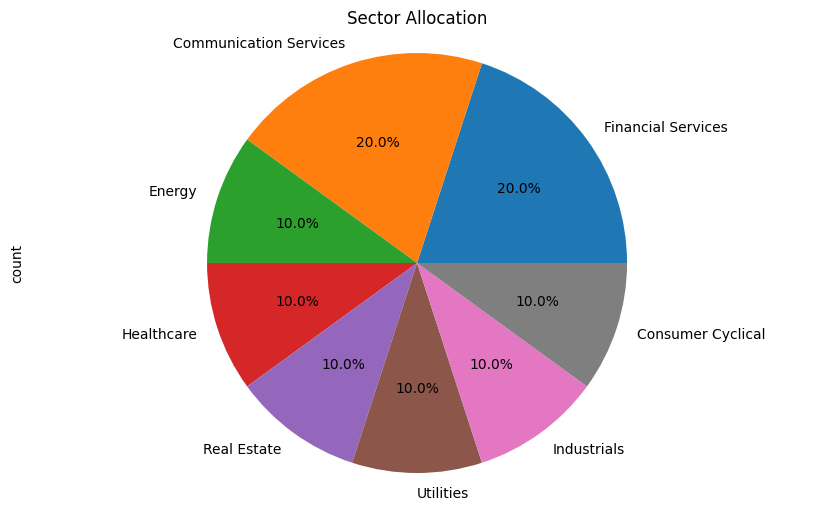

In [26]:
def create_hybrid_portfolio(traditional_portfolio, ml_portfolio, metrics_df, historical_data):
    """Create a hybrid portfolio combining traditional and ML approaches"""

    def calculate_score(row, return_weight=0.4, risk_weight=0.3, growth_weight=0.3):
        return_score = row['Annual_Return'] if not np.isnan(row['Annual_Return']) else 0
        vol_score = 1 / row['Volatility'] if not np.isnan(row['Volatility']) else 0
        growth_score = row['Revenue_Growth'] if not np.isnan(row['Revenue_Growth']) else 0

        return (return_score * return_weight +
                vol_score * risk_weight +
                growth_score * growth_weight)

    # Combine unique stocks from both portfolios
    all_tickers = list(set(traditional_portfolio['Ticker'].head(10).tolist() +
                          ml_portfolio['Ticker'].head(10).tolist()))

    # Create hybrid portfolio dataframe
    portfolio_data = []

    for ticker in all_tickers:
        # Get stock data
        stock_data = historical_data[ticker]['Close']
        returns = stock_data.pct_change()

        # Calculate metrics
        annual_return = returns.mean() * 252
        volatility = returns.std() * np.sqrt(252)

        # Get fundamental data
        stock_metrics = metrics_df[metrics_df['Ticker'] == ticker].iloc[0]

        portfolio_data.append({
            'Ticker': ticker,
            'Annual_Return': annual_return,
            'Volatility': volatility,
            'Sharpe': annual_return / volatility if volatility != 0 else 0,
            'Revenue_Growth': stock_metrics['Revenue_Growth'],
            'PE_Ratio': stock_metrics['PE_Ratio'],
            'PB_Ratio': stock_metrics['PB_Ratio'],
            'In_Traditional': ticker in traditional_portfolio['Ticker'].head(10).values,
            'In_ML': ticker in ml_portfolio['Ticker'].head(10).values
        })

    hybrid_df = pd.DataFrame(portfolio_data)

    # Calculate hybrid score
    hybrid_df['Hybrid_Score'] = hybrid_df.apply(calculate_score, axis=1)

    # Sort and select top stocks
    hybrid_df = hybrid_df.sort_values('Hybrid_Score', ascending=False)

    print("\nHybrid Portfolio Selection:")
    print(hybrid_df[['Ticker', 'Annual_Return', 'Volatility', 'Revenue_Growth',
                     'PE_Ratio', 'In_Traditional', 'In_ML',
                     'Hybrid_Score']].head(10).round(3))

    # Calculate sector exposure
    sector_info = {}
    for ticker in hybrid_df['Ticker'].head(10):
        try:
            stock = yf.Ticker(ticker)
            sector_info[ticker] = stock.info.get('sector', 'Unknown')
        except:
            sector_info[ticker] = 'Unknown'

    print("\nSector Exposure:")
    sector_exposure = pd.Series(sector_info).value_counts()
    print(sector_exposure)

    # Portfolio metrics
    top_10 = hybrid_df.head(10)
    print("\nHybrid Portfolio Metrics:")
    print(f"Average Annual Return: {top_10['Annual_Return'].mean():.1%}")
    print(f"Average Volatility: {top_10['Volatility'].mean():.1%}")
    print(f"Average Revenue Growth: {top_10['Revenue_Growth'].mean():.1%}")
    print(f"Average PE Ratio: {top_10['PE_Ratio'].mean():.1f}")

    # Create visualization
    plt.figure(figsize=(12, 6))

    # Plot all stocks
    plt.scatter(hybrid_df['Volatility'], hybrid_df['Annual_Return'],
                alpha=0.5, label='All Stocks')

    # Plot selected stocks
    top_10_scatter = plt.scatter(top_10['Volatility'], top_10['Annual_Return'],
                                color='red', label='Selected Stocks')

    # Add ticker labels for selected stocks
    for _, row in top_10.iterrows():
        plt.annotate(row['Ticker'],
                    (row['Volatility'], row['Annual_Return']))

    plt.xlabel('Volatility')
    plt.ylabel('Annual Return')
    plt.title('Risk-Return Profile of Hybrid Portfolio')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot sector allocation
    plt.figure(figsize=(10, 6))
    sector_exposure.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Sector Allocation')
    plt.axis('equal')
    plt.show()

    return hybrid_df.head(10)

# Create hybrid portfolio
hybrid_portfolio = create_hybrid_portfolio(top_stocks, final_results, metrics_df, historical_data)